<a href="https://colab.research.google.com/github/jhlee93/Baseline/blob/main/ImageClassification/augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
# 데이터세트 다운로드
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)
print(data_dir)

228827136/228813984 [==============================] - 5s 0us/step
/root/.keras/datasets/flower_photos


In [3]:
print(os.listdir(data_dir))
image_count = len(list(data_dir.glob('*/*.jpg')))
print('image count: ', image_count)

['dandelion', 'tulips', 'roses', 'sunflowers', 'LICENSE.txt', 'daisy']
image count:  3670


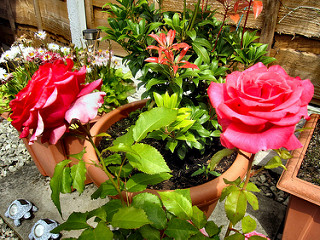

In [4]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

# keras preprocessing을 사용하여 데이터 로드

In [5]:
# 데이터 로드를 위해 매개변수 정의
batch_size = 32
img_height = 180
img_width = 180

In [6]:
# tf.keras.preprocessing.image_dataset_from_directory API를 활용하여 폴더별로 구분된 클래스들을 알아서 불러옴
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir, # 클래스별로 구분된 상위 디렉토리 경로
    validation_split=0.2, # 검증셋 20% 분할
    subset='training', # 학습 데이터셋
    seed=123, # 재현성 검증을 위해 무작위성 고정
    image_size=(img_height, img_width), # 이미지 shape을 아래와 같이 변형시켜 가져옴
    batch_size=batch_size # 학습 배치사이즈 지정
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [7]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [8]:
# image_dataset_from_directory를 통해 로드된 데이터셋은 아래와 같이 확인 가능
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


# 데이터 확인

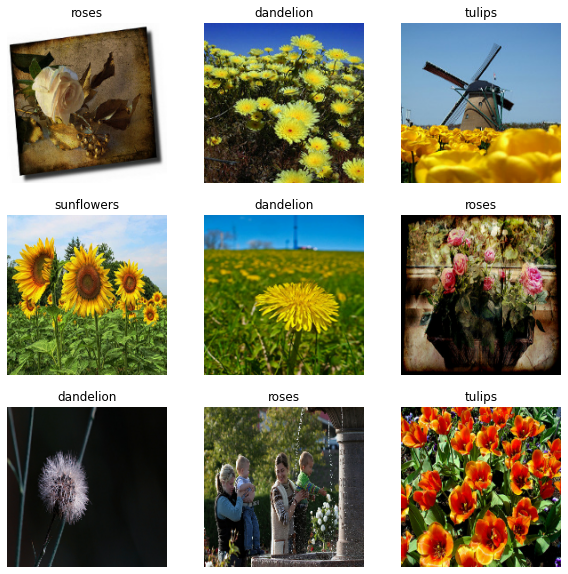

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')


In [10]:
# image_dataset_from_directory 를 통해 로드된 데이터셋이 어떤 식으로 가져오는지 확인
# 사전에 배치사이즈, 이미지 크기를 설정했기 때문에 정의된 배치 사이즈만큼 이미지와 정답을 가져옴
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


Dataset.cache()는 첫 epoch 동안 디스크에서 이미지를 로드한 후 이미지를 메모리에 유지합니다. 이렇게 하면 모델을 훈련하는 동안 데이터세트가 병목 상태가 되지 않습니다. 데이터세트가 너무 커서 메모리에 맞지 않는 경우, 이 메서드를 사용하여 성능이 높은 온디스크 캐시를 생성할 수도 있습니다.

Dataset.prefetch()는 훈련 중에 데이터 전처리 및 모델 실행과 겹칩니다.

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# 데이터 정규화

In [12]:
# 이미지 픽셀값을 0~1 사이값으로 정규화/표준화하여 학습이 진행되도록 모델을 구성
num_classes = len(class_names)
model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(filters=16, kernel_size=3, padding='same', activation='relu'),
    layers.MaxPooling2D(), # 기본값 pool_size=(2,2)를 사용 
    layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)

])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [13]:
# 모델 컴파일
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [14]:
epochs=100
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/100
92/92 [==============================] - 21s 61ms/step - loss: 1.3057 - accuracy: 0.4557 - val_loss: 1.1359 - val_accuracy: 0.5531
Epoch 2/100
92/92 [==============================] - 4s 42ms/step - loss: 0.9807 - accuracy: 0.6192 - val_loss: 1.0335 - val_accuracy: 0.5872
Epoch 3/100
92/92 [==============================] - 4s 45ms/step - loss: 0.7987 - accuracy: 0.6945 - val_loss: 0.9079 - val_accuracy: 0.6499
Epoch 4/100
92/92 [==============================] - 5s 52ms/step - loss: 0.5523 - accuracy: 0.7973 - val_loss: 0.9963 - val_accuracy: 0.6390
Epoch 5/100
92/92 [==============================] - 5s 52ms/step - loss: 0.3323 - accuracy: 0.8856 - val_loss: 1.1257 - val_accuracy: 0.6540
Epoch 6/100
92/92 [==============================] - 5s 51ms/step - loss: 0.1918 - accuracy: 0.9373 - val_loss: 1.4283 - val_accuracy: 0.6362
Epoch 7/100
92/92 [==============================] - 5s 51ms/step - loss: 0.0956 - accuracy: 0.9728 - val_loss: 1.4605 - val_accuracy: 0.6458
Epoch

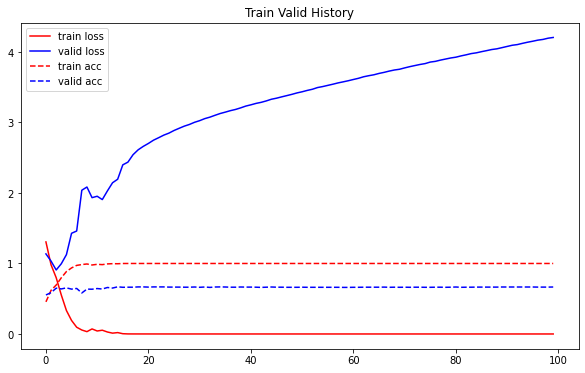

In [15]:
train_loss = history.history['loss']
valid_loss = history.history['val_loss']

train_acc = history.history['accuracy']
valid_acc = history.history['val_accuracy']

plt.figure(figsize=(10,6))
plt.plot(range(epochs), train_loss, label='train loss', c='r')
plt.plot(range(epochs), valid_loss, label='valid loss', c='b')
plt.plot(range(epochs), train_acc, '--', label='train acc', c='r')
plt.plot(range(epochs), valid_acc, '--', label='valid acc', c='b')
plt.title('Train Valid History')
plt.legend()
plt.show()

# 데이터 증강

In [33]:
data_augmentation = keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", input_shape=(img_height, img_width, 3)),
    layers.experimental.preprocessing.RandomRotation(0.3),
    layers.experimental.preprocessing.RandomZoom(0.2),
])

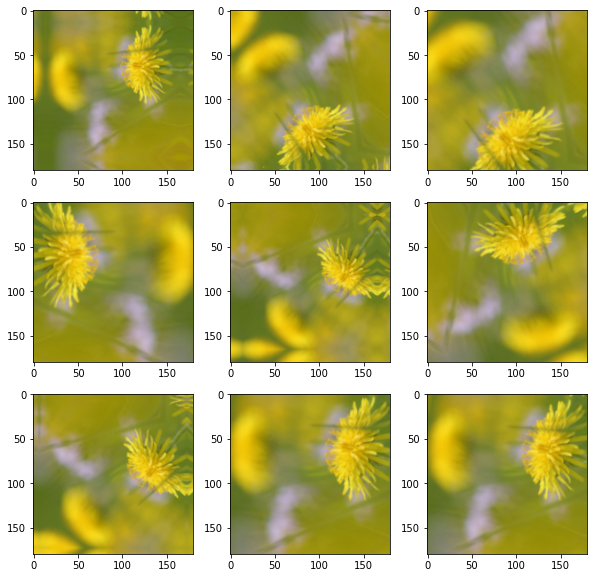

In [53]:
# 증강된 데이터 시각화하기
for images, labels in train_ds.take(1):
    tf_sample_image = images[0:1] # 1 batch

    plt.figure(figsize=(10,10))
    for i in range(9):
        augmented_image = data_augmentation(tf_sample_image)
        ax = plt.subplot(3,3,i+1)
        ax.imshow(augmented_image[0].numpy().astype(np.uint8))

In [54]:
model2 = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [55]:
# 모델 컴파일
model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [56]:
epochs=100
history = model2.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/100
92/92 [==============================] - 9s 63ms/step - loss: 1.4084 - accuracy: 0.4046 - val_loss: 1.1811 - val_accuracy: 0.5259
Epoch 2/100
92/92 [==============================] - 5s 52ms/step - loss: 1.0734 - accuracy: 0.5763 - val_loss: 0.9863 - val_accuracy: 0.6049
Epoch 3/100
92/92 [==============================] - 5s 58ms/step - loss: 0.9951 - accuracy: 0.6066 - val_loss: 0.9385 - val_accuracy: 0.6158
Epoch 4/100
92/92 [==============================] - 5s 53ms/step - loss: 0.9418 - accuracy: 0.6284 - val_loss: 0.9110 - val_accuracy: 0.6226
Epoch 5/100
92/92 [==============================] - 5s 52ms/step - loss: 0.8967 - accuracy: 0.6461 - val_loss: 0.8893 - val_accuracy: 0.6444
Epoch 6/100
92/92 [==============================] - 5s 52ms/step - loss: 0.8783 - accuracy: 0.6584 - val_loss: 0.9469 - val_accuracy: 0.6349
Epoch 7/100
92/92 [==============================] - 5s 52ms/step - loss: 0.8435 - accuracy: 0.6846 - val_loss: 0.8034 - val_accuracy: 0.6676
Epoch 

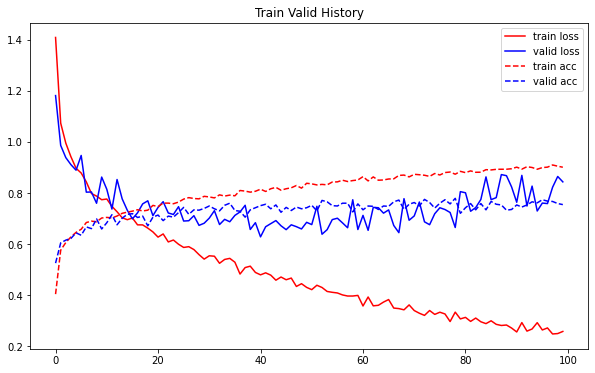

In [57]:
train_loss = history.history['loss']
valid_loss = history.history['val_loss']

train_acc = history.history['accuracy']
valid_acc = history.history['val_accuracy']

plt.figure(figsize=(10,6))
plt.plot(range(epochs), train_loss, label='train loss', c='r')
plt.plot(range(epochs), valid_loss, label='valid loss', c='b')
plt.plot(range(epochs), train_acc, '--', label='train acc', c='r')
plt.plot(range(epochs), valid_acc, '--', label='valid acc', c='b')
plt.title('Train Valid History')
plt.legend()
plt.show()